In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Loading Data

In [28]:
img_ref = cv2.imread('./frame000000.jpg')[:,:,::-1]
img_next = cv2.imread('./frame000020.jpg')[:,:,::-1]

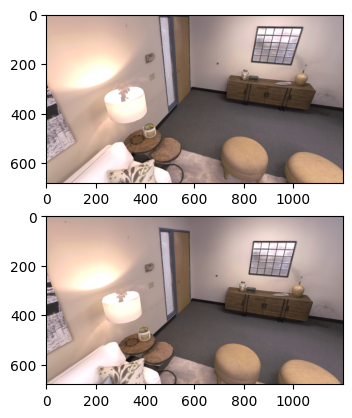

In [29]:
plt.subplot(2,1,1)
plt.imshow(img_ref)
plt.subplot(2,1,2)
plt.imshow(img_next)

## Keypoint Detection

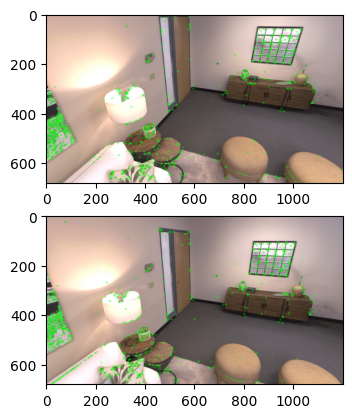

In [30]:
# create orb detector
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img_ref,None)
kp2, des2 = sift.detectAndCompute(img_next,None)

vis1 = cv2.drawKeypoints(img_ref, kp1, None, color=(0,255,0), flags=0)
vis2 = cv2.drawKeypoints(img_next, kp2, None, color=(0,255,0), flags=0)

plt.subplot(2,1,1)
plt.imshow(vis1)
plt.subplot(2,1,2)
plt.imshow(vis2)
plt.show()

# Keypoint Matching

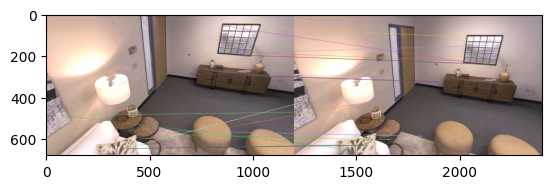

In [31]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

#sort matches by best
matches = sorted(matches, key = lambda x:x[0].distance)

img3 = cv2.drawMatchesKnn(img_ref,kp1,img_next,kp2,matches[:10],None,flags=2)
plt.imshow(img3)

## Get Fundamental Matrix

In [51]:
pts1 = []
pts2 = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.5*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

#find fundamental matrix
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_8POINT)

# mask out rejected points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

## Convert Fundamental Matrix to Essential Matrix

In [52]:
'''
dataset_name: 'replica'
camera_params:
  image_height: 680
  image_width: 1200
  fx: 600.0
  fy: 600.0
  cx: 599.5
  cy: 339.5
  png_depth_scale: 6553.5
  crop_edge: 0
'''
fx = 600.0
fy = 600.0
cx = 599.5
cy = 339.5

K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])

E = K.T @ F @ K # essential matrix calculation

R1, R2, t = cv2.decomposeEssentialMat(E)
t1 = t
t2 = -t

# Triangulation

In [53]:
def triangulate(ptsL, ptsR, K, R, t):
    qL = ptsL.copy()
    qR = ptsR.copy()
    
    # fx = K[0,0]
    # fy = K[1,1]
    # cx = K[0,2]
    # cy = K[1,2]
    
    # c = np.array([[cx], [cy]])
    
    #setup equations
    qL = np.linalg.inv(K) @ np.vstack((qL, np.ones((1,qL.shape[1]))))
    qR = np.linalg.inv(K) @ np.vstack((qR, np.ones((1,qR.shape[1]))))
    
    Rlql = qL
    Rrqr = (R @ qR) * (-1)
    b = t
    
    #formualte optimization problem
    zhatL = np.zeros(shape=(1,ptsL.shape[1]))
    zhatR = np.zeros(shape=(1,ptsR.shape[1]))
    for i in range(ptsL.shape[1]):
        R_lidx = Rlql[:,i].reshape(3,1)
        R_ridx = Rrqr[:,i].reshape(3,1)
        A = np.hstack([R_lidx, R_ridx])
        
        zhat = np.linalg.lstsq(A, b, rcond=None)[0]
        zhatL[:,i] = zhat[0]
        zhatR[:,i] = zhat[1]
    #afterward use solution to solve for points
    PL = zhatL * qL
    PR = zhatR * qR
    
    P1 = PL
    P2 = R @ PR + t
    pts3 = (P1+P2)/2
    return pts3

In [54]:
# check cheirality conditions by running triangulate on all 4 possible combinations of R1, R2, t
# 1: [R1, t]
# 2: [R1, -t]
# 3: [R2, t]
# 4: [R2, -t]

pts3_1 = triangulate(pts1.T, pts2.T, K, R1.T, -R1.T@t1)
pts3_2 = triangulate(pts1.T, pts2.T, K, R1.T, -R1.T@t2)
pts3_3 = triangulate(pts1.T, pts2.T, K, R2.T, -R2.T@t1)
pts3_4 = triangulate(pts1.T, pts2.T, K, R2.T, -R2.T@t2)

s1 = (pts3_1[2,:] > 0).sum()
s2 = (pts3_2[2,:] > 0).sum()
s3 = (pts3_3[2,:] > 0).sum()
s4 = (pts3_4[2,:] > 0).sum()

max_sum = max(s1, s2, s3, s4)
print(s1,s2,s3,s4)
print(pts3_1.shape)
if max_sum == s1:
    pts3 = pts3_1
    R = R1.T
    t = -R1.T@t1
elif max_sum == s2:
    pts3 = pts3_2
    R = R1.T
    t = -R1.T@t2
elif max_sum == s3:
    pts3 = pts3_3
    R = R2.T
    t = -R2.T@t1
else:
    pts3 = pts3_4
    R = R2
    t = -R2.T@t2


440 15 0 455
(3, 455)


In [55]:
rotvec = cv2.Rodrigues(R)[0]
print(rotvec)
print(t)

[[-0.09962333]
 [ 0.03288961]
 [ 0.01502409]]
[[ 0.68026522]
 [ 0.62698386]
 [-0.3796452 ]]
